In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

## Mini-project: `Coordinate descent`

In this project, we consider a standard `unconstrained optimization` problem on `heart disease data set`:

$$min L(w)$$

where $L(·)$ is some cost function and $w \in \mathbb{R}^d$. In class, we looked at several approaches to solving such
problems—such as `gradient descent` and `stochastic gradient descent`—under differentiability conditions on
$L(w)$. We will now look at a different, and in many ways simpler, approach:
- Initialize $w$ somehow.
- Repeat: pick a coordinate $i \in \{1, 2, ... , d\}$, and update the value of $w_i$ so as to reduce the loss.

Two questions need to be answered in order to fully specify the updates:

- (i) Which coordinate to choose?
- (ii) How to set the new value of $w_i$?

### (a) *A short, high-level description of coordinate descent method*. 

#### Key Strategies:
- Objective function(Loss function) and gradients:

The Maximum likelihood estimation of logistic regression is in a form of:

$$
L(w) = -1/n\displaystyle\sum_{i=1}^{n} y_{i} \log \hat{y}_{i} + (1 - y_{i}) \log(1 - \hat{y}_{i})
$$

We transform $\hat y = w^T x_i +b$ by a Sigmoid function $\sigma(x)=\frac{1}{1+e^{-x}}$,
hence, the loss function can be writen as:

$$
L(w) = -1/n\displaystyle\sum_{i=1}^{n} y_{i} \log \sigma(\hat{y}_{i}) + (1 - y_{i}) \log(1 - \sigma(\hat{y}_{i}))
$$

Thus, the coordinate gradient with respect with each weight $w_{j}$ is given by

$$
\frac{\partial L(w)}{\partial w_{j}} = \displaystyle \sum_{i=1}^{n}(\sigma(\hat{y}_{i}) - y_{i})x_{j}
$$

- Rules for selecting coordinates besides randomly choose a $w_i$ at a time: 
    - **Method 1 (Cyclic coordinate descent)**: go through all the features cyclically. (1,2,..13,1,2,...13,1,2...until converge.)
    - **Method 2 (Gauss-Southwell)**: at each iteration, pick coordinate $i$ that has greatest gradient in absolute value for which:

$$i = \underset{1 \leq j \leq n}{\operatorname{argmax}|\nabla_j f(x^{(t)})|}$$

$$\nabla_j f(x^{(t)}) = \frac{\partial L(w)}{\partial w_{j}} = \displaystyle \sum_{i=1}^{n}(\sigma(\hat{y}_{i}) - y_{i})x_{j}$$

- Rules for updating $\omega_i$: 
$$
w_{i} = w_{i} - \eta \frac{\partial L(w)}{\partial w_{i}}
$$
Here, $\eta$ denotes step size.


- Constraint on loss function: **L(·) should be convex and differentiable**.

### (b) *Convergence*.

Under what conditions do you think your method converges to the optimal loss?

The objective function(Loss function) values are non-decreasing: $f(x(0)) \geq f(x(1)) \geq f(x(2)) ...$, if $f$ is strictly convex and differentiable, the algorithm converges to a global minimum. Hence, we we let iterations keep going until the loss gets as close to as $L^*$, which is the fitting Loss of our baseline logistic regrssion model. 

We will take the difference between fitting loss and $L^*$, if the difference is less than $0.001$, we will consider the fitting process converged to a gloabal minimum, then the iterations will terminate.

### (c) *Experimental results*.

Prepare data

In [2]:
data = np.loadtxt('heart.csv', delimiter=',', skiprows=1)

In [3]:
X, y = data[:, :-1], data[:,-1]

# normalize features
X = (X - X.mean(axis=0))/(X.max(axis=0) - X.min(axis=0))

# add intercept-1 vector to feature matrix
X = np.hstack((X, np.ones((X.shape[0], 1))))

In [4]:
X.shape

(303, 14)

In [5]:
np.ones((X.shape[0], 1)).shape

(303, 1)

#### Baseline Loss on Logistic Regression

Begin by running a standard logistic regression solver(not regularized) on the training set. Make note of the final loss $L^*$. 

In [7]:
# baseline logistic regression model without regularization
reg = LogisticRegression(solver='sag', C=100000, max_iter = 10000).fit(X, y)
L_base = log_loss(y, reg.predict_proba(X))

print(f"Baseline(Logistic Regression) Training Loss L* = {L_base}")

Baseline(Logistic Regression) Training Loss L* = 0.34890424492559446


Then, implement your coordinate descent method and run it on this data.

#### Implementing CoordinateDescent Classifier.

In [8]:
class CoordinateDescent():

    def __init__(self, target, select, step=0.01):    
        """Create a Coordinate Descent Classifier.
        
        Given training data and labels, this class calculates the coefficients 
        based on coordinate descent.
        
        Parameters
        ----------
        target, fitting loss when converged 
        select, the strategy for selecting which w_i to update 
        step, learning rate
        
        Attributes
        ----------
        target, fitting loss when converged 
        select, the strategy for selecting which w_i to update 
        step, learning rate
        """
        self.target = target
        self.step = step
        self.select = select
     
    
    def __sigmoid(self, x):
        """Squashing function.
        
        Parameters
        ----------
        x, A numpy ndarray, shape of (number of samples, number of features)
        
        Returns
        ----------
        A numpy ndarray, shape of (number of samples, number of features)
        """
        return 1 / (1 + np.exp(-x))
        
        
    def fit(self, X, y):
        """Update coefficient based on different strategy of selecting one coordinate each time.
        Fitting process will be ended while converging criteria met.
        
        Parameters
        ----------
        X, A numpy ndarray, training data, shape of (number of samples, number of features)
        y, A numpy ndarray, training label, shape of (number of samples,)
        
        Returns
        ----------
        The current object
        """
        self.n_features = X.shape[1]
        w = np.zeros(self.n_features).reshape(self.n_features, 1)
        self.L = []
        
        diff = 1
        cycle_digit = 0
        self.num_iter = 0
        
        while diff >= 0.001: 
            y_hat = self.__sigmoid(np.dot(w.T, X.T))
            loss = -(1 / X.shape[0]) * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
            self.L.append(loss)
            delta = list(np.dot((y_hat - y), X)[0]) # gradients

            cycle_index = cycle_digit % X.shape[1]
            
            if self.select == 'cgd': # select with largest gradient in absolute value
                to_update = np.argmax(np.abs(delta))
                w[to_update] = w[to_update] - self.step * delta[to_update]
            elif self.select == 'rand': # randomly select coordinate
                random = np.random.randint(0,13)
                w[random] = w[random] - self.step * delta[random]
            elif self.select == 'cycle': # cyclic go through all coordinate
                w[cycle_index] = w[cycle_index] - self.step * delta[cycle_index]
                cycle_digit += 1 
            
            self.num_iter += 1
            diff = loss - self.target
            
            self.w = w
            
        return self
   

    def predict(self, X):
        """Calculate OLS result with coefficients trained by fittting.
        
        Parameters
        ----------
        X, A numpy ndarray, shape of (number of samples, number of features)
        
        Returns
        ----------
        y_pred, A numpy ndarray, shape of (number of samples,)
        """
        y_pred = self.__sigmoid(np.dot(self.w.T, X.T))
        y_pred = np.array(list(map(lambda x: 1 if x >= 0.5 else 0, y_pred.flatten())))
        return y_pred
   

    def get_loss(self):
        """
        Returns
        ----------
        self.L, A list, fitting loss of each update
        """
        return self.L
    
    
    def get_coef(self):
        """
        Returns
        ----------
        self.w, A numpy ndarray, fitted coefficients, shape of (number of features,)
        """
        return self.w
    
    
    def get_num_iter(self):
        """
        Returns
        ----------
        self.num_iter, A number, the number of updates during fitting.
        """
        return self.num_iter

#### Method 1: Cyclic go through each coordinate $i$ 

In [9]:
# fit training data with coordinate descent model(default 1050 iterations)
m1 = CoordinateDescent(target=L_base, select='cycle').fit(X, y)
m1_pred = m1.predict(X)

In [10]:
# Accuracy
m1_acc = accuracy_score(y, m1_pred)
# Training Loss
L1 = m1.get_loss()
num_iter1 = m1.get_num_iter()

print(f"Go through each coordinate cyclically: \n\
-------------------------------------- \
\nAccuracy:       -> {m1_acc} \
\nFitting Loss:   -> {L1[-1]} \
\n#Iterations:    -> {num_iter1}")

Go through each coordinate cyclically: 
-------------------------------------- 
Accuracy:       -> 0.8514851485148515 
Fitting Loss:   -> 0.349902342590921 
#Iterations:    -> 3576


#### Method 2: Pick coordinate $i$ that has greatest gradient in absolute value at each iteration

In [11]:
# fit training data with coordinate descent model
m2 = CoordinateDescent(target=L_base, select='cgd').fit(X, y)
m2_pred = m2.predict(X)

In [12]:
# Accuracy
m2_acc = accuracy_score(y, m2_pred)
# Training Loss
L2 = m2.get_loss()
num_iter2 = m2.get_num_iter()

print(f"Select feature based on largest gradient: \n\
----------------------------------------- \
\nAccuracy:       -> {m2_acc} \
\nFitting Loss:   -> {L2[-1]} \
\n#Iterations:    -> {num_iter2}")

Select feature based on largest gradient: 
----------------------------------------- 
Accuracy:       -> 0.8382838283828383 
Fitting Loss:   -> 0.3499040333347324 
#Iterations:    -> 1622


  - Finally, compare to a method that chooses coordinates $i$ uniformly at random and then updates $w_i$ using your method (we’ll call this “random-feature coordinate descent”).

In [13]:
m3 = CoordinateDescent(target=L_base, select='rand').fit(X, y)
m3_pred = m3.predict(X)

In [15]:
# Accuracy
m3_acc = accuracy_score(y, m3_pred)
# Training Loss
L3 = m3.get_loss()
num_iter3 = m3.get_num_iter()

print(f"Randomly select coordinate: \n\
---------------------------------- \
\nAccuracy:       -> {m3_acc} \
\nFitting Loss:   -> {L3[-1]} \
\n#Iterations:    -> {num_iter3}")

Randomly select coordinate: 
---------------------------------- 
Accuracy:       -> 0.8514851485148515 
Fitting Loss:   -> 0.3499039468571106 
#Iterations:    -> 5031


### Conclusion

Three different methods all converged to $L^*$ within a sufficiently small range, however, they do take different number of iterations to achieve their results, apparently selecting coordinate based on the largest coordinate gradient requires the smallest number of iterations($1622$), which indicating this method converging faster than the others, respectively, cyclic coordinate gradient takes $3576$ iterations, random selecting takes 4800~5500 times, for random selecting, even though the number of iterations may differ each time, the difference is trivial.

We visualize this result by plotting the fitting curves below.

In [16]:
def plot_loss():
    plt.figure(figsize=(10,6))

    plt.plot(L1, 'green', label='"Cyclic Coordinate Descent"')
    plt.plot(L2, 'red', label='"Coordinate Gradient Descent"')
    plt.plot(L3, 'orange', label='"Random Coordinate Descent"')
    plt.axhline(y=L_base, color='lightblue', label='Baseline L*')
    plt.title('Coordinate Descent Fitting Loss', fontsize=16)
    plt.xlabel('Iterations', fontsize=16)

    plt.ylabel('Fitting Loss', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(prop={'size': 16})

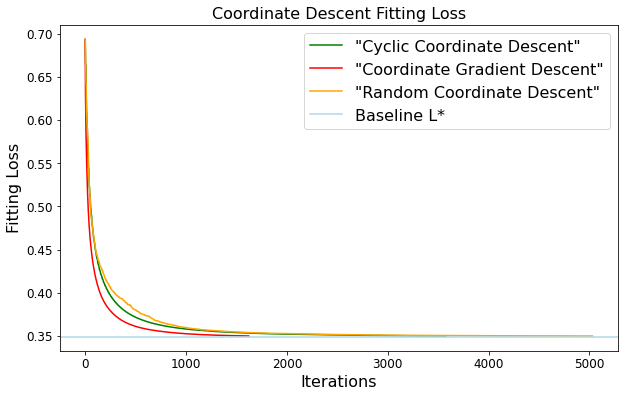

In [17]:
plot_loss()

The graph above shows how the loss of our "adaptive" coordinate descent algorithm's current iterate—that is, $L(w_t)$—decreases with $t$; it should asymptote to $L^*$. Also, it shows the corresponding curve for random-feature coordinate descent.